# Assignment 4

# 1)

## a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def roll_dice(n_sides, n_rolls, plot=True):
    rolls = np.random.randint(1, n_sides + 1, size=n_rolls)
    if plot:
        plt.hist(rolls, bins=np.arange(1, n_sides + 2) - 0.5, rwidth=0.8, alpha=0.75)
        plt.xlabel('Die Result')
        plt.ylabel('Frequency')
        plt.title(f'Die Result Histogram for {n_rolls} rolls')
        plt.xticks(range(1, n_sides + 1))
        plt.show()
    return np.mean(rolls), rolls

## b)

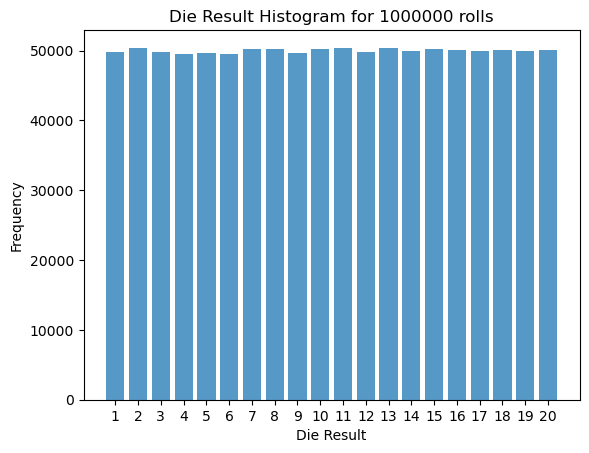

Average roll value: 10.508449


In [2]:
n_sides = 20
n_rolls = 1000000
average, _ = roll_dice(n_sides, n_rolls)
print(f'Average roll value: {average}')

Yes, we expect the average to be 10.5, since dice rolling is uniform (as demonstrated by the histogram), centered at 10.5 = (1+20)/2.

## c)

In [3]:
def roll_dice_get_max(n_sides, n_rolls):
    _, rolls = roll_dice(n_sides, n_rolls, plot=False)
    return rolls.max()

## d

In [4]:
def roll_dice_get_max_m_times(n_sides, n_rolls, m):
    max_rolls = []
    for i in tqdm(range(m)):
        max_rolls.append(roll_dice_get_max(n_sides, n_rolls))
    return max_rolls

In [5]:
n_sides = 20
n_rolls = 2
m = 1000000
max_rolls = roll_dice_get_max_m_times(n_sides, n_rolls, m)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:41<00:00, 24007.12it/s]


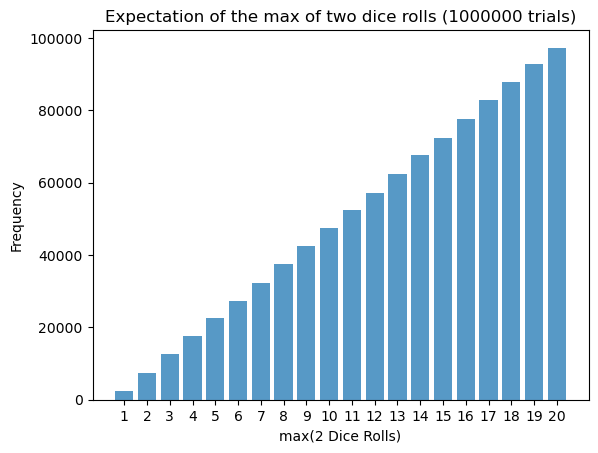

In [6]:
plt.hist(max_rolls, bins=np.arange(1, n_sides + 2) - 0.5, rwidth=0.8, alpha=0.75)
plt.xlabel('max(2 Dice Rolls)')
plt.ylabel('Frequency')
plt.title(f'Expectation of the max of two dice rolls (1000000 trials)')
plt.xticks(range(1, n_sides + 1))
plt.show()

The histogram makes sense, as we expect a linear relationship in E(max(X, X)) for 2 dice rolls as the possibilities for X = k for k in [1, 2, ..., n_sides] increase by 2 as k increases by 1.

# 2)

In [7]:
import ipywidgets as ipw
from scipy import integrate

In [8]:
%matplotlib widget

In [9]:
def SZR(y, t, N, Pi, delta, beta, zeta, alpha):
    S, Z, R = y
    dotS = Pi - beta * S * Z - delta * S
    dotZ = beta * S * Z + zeta * R - alpha * Z * S
    dotR = delta * S + alpha * Z * S - zeta * R
    return np.array([dotS, dotZ, dotR])

interactive(children=(FloatSlider(value=0.2, description='Pi', max=1.0, step=0.01), FloatSlider(value=0.2, des…

<function __main__.update(Pi=0.2, delta=0.2, beta=0.2, zeta=0.2, alpha=0.2)>

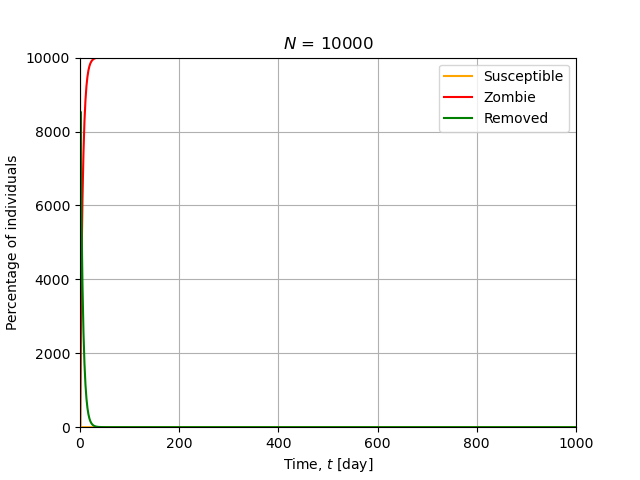

In [10]:
def update(Pi=0.2, delta=0.2, beta=0.2, zeta=0.2, alpha=0.2):
    """
    Update function.
    """
    Z0, R0 = 1, 0
    S0 = N - Z0 - R0
    X0 = S0, Z0, R0

    sol = integrate.odeint(SZR, X0, t, args = (N, Pi, delta, beta, zeta, alpha))
    line0.set_ydata(sol[:, 0])
    line1.set_ydata(sol[:, 1])
    line2.set_ydata(sol[:, 2])
    ax.set_title("$N$ = {0}".format(str(N)))
    fig.canvas.draw()
    fig.canvas.flush_events()

Nt = 1000
tmax = 1000
t = np.linspace(0., tmax, Nt)
X = np.zeros((Nt,3))
N=10000
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.grid()
line0, = ax.plot(t, X[:,0], "orange", label = "Susceptible")
line1, = ax.plot(t, X[:,1], "r", label = 'Zombie')
line2, = ax.plot(t, X[:,2], "g", label = 'Removed')
ax.set_xlim(0., tmax)
ax.set_ylim(0., N)
ax.set_xlabel("Time, $t$ [day]")
ax.set_ylabel("Percentage of individuals")
plt.legend()

ipw.interact(update, Pi=(0.,1., 0.01), delta=(0.,1., 0.01), beta=(0.,1., 0.01), zeta=(0.,1., 0.01), alpha=(0.,1., 0.01))

In [11]:
plt.close()

Without doing a proper sensitivity analysis, its hard to draw conclusions about what the best approach would be. Of note though, its clear that as beta and zeta approach 0, as long as alpha is nonzero, the apocolypse will end. Realistically, should there be an apocoloypse, the arguably most controllable parameter would be the transmission rate, in which reducing it would have the most immediate effect in my opinion.

# 3)

In [12]:
from modsim import *

In [13]:
def step(state, p1, p2, p3, p4, p5, p6):
    """Simulate one time step
    """
    if flip(p1):
        bike_X_to_Y(state, 'A', 'B')
    if flip(p2):
        bike_X_to_Y(state, 'A', 'C')
    if flip(p3):
        bike_X_to_Y(state, 'B', 'A')
    if flip(p4):
        bike_X_to_Y(state, 'B', 'C')
    if flip(p5):
        bike_X_to_Y(state, 'C', 'A')
    if flip(p6):
        bike_X_to_Y(state, 'C', 'B')
        
def bike_X_to_Y(state, X, Y):
    """Move one bike from X to Y.
    
    state: bikeshare State object
    """
    if state[X] == 0:
        state[X + '_empty'] += 1
        return
    state[X] -= 1
    state[Y] += 1

def run_simulation(state, p1, p2, p3, p4, p5, p6, num_steps):
    """Simulate the given number of time steps.
    
    state: State object
    p1: probability of an B->A customer arrival
    p2: probability of a A->B customer arrival
    num_steps: number of time steps
    """
    results_C = TimeSeries()
    results_C[0] = state.C
    results_B = TimeSeries()
    results_B[0] = state.B
    results_A = TimeSeries()
    results_A[0] = state.A
    results_C_unsatisfied = TimeSeries()
    results_C_unsatisfied[0] = state.C_empty
    results_B_unsatisfied = TimeSeries()
    results_B_unsatisfied[0] = state.B_empty
    results_A_unsatisfied = TimeSeries()
    results_A_unsatisfied[0] = state.A_empty
    
    for i in range(num_steps):
        step(state, p1, p2, p3, p4, p5, p6)
        results_C[i+1] = state.C
        results_B[i+1] = state.B
        results_A[i+1] = state.A
        results_C_unsatisfied[i+1] = state.C_empty
        results_B_unsatisfied[i+1] = state.B_empty
        results_A_unsatisfied[i+1] = state.A_empty
    
    return results_C_unsatisfied[num_steps-1] + results_B_unsatisfied[num_steps-1] + results_A_unsatisfied[num_steps-1]

In [18]:
num_steps = 180
num_sims = 100
N_slots = 100

p1 = 0.3
p2 = 0.2
p3 = 0.4
p4 = 0.1
p5 = 0.35
p6 = 0.15

In [25]:
N_start_C = 10
N_start_B = 30
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]

Average unsatisfied customers:  28.01


In [26]:
N_start_C = 10
N_start_B = 60
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]

Average unsatisfied customers:  27.2


In [27]:
N_start_C = 60
N_start_B = 10
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]

Average unsatisfied customers:  5.56


In [28]:
N_start_C = 30
N_start_B = 10
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]

Average unsatisfied customers:  15.23


In [29]:
N_start_C = 60
N_start_B = 30
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]

Average unsatisfied customers:  0.16


In [30]:
N_start_C = 30
N_start_B = 60
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]

Average unsatisfied customers:  8.47


In [32]:
N_start_C = 60
N_start_B = 40
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]

Average unsatisfied customers:  1.76


In [33]:
N_start_C = 50
N_start_B = 50
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]

Average unsatisfied customers:  1.95


In [34]:
N_start_C = 58
N_start_B = 28
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]

Average unsatisfied customers:  0.31


In [35]:
N_start_C = 62
N_start_B = 32
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]

Average unsatisfied customers:  0.12


In [36]:
N_start_C = 62
N_start_B = 34
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]

Average unsatisfied customers:  0.17


In [37]:
N_start_C = 64
N_start_B = 32
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]

Average unsatisfied customers:  0.36


In [38]:
N_start_C = 61
N_start_B = 31
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]

Average unsatisfied customers:  0.23


In [40]:
N_start_C = 60
N_start_B = 31
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]

Average unsatisfied customers:  0.0


In [41]:
N_start_C = 61
N_start_B = 30
N_start_A = N_slots - N_start_B - N_start_C
tu_sum = 0
for j in tqdm(range(num_sims)):
    bikeshare = State(C=N_start_C, B=N_start_B, A=N_start_A,
              C_empty=0, B_empty=0, A_empty=0)
    total_unsatisfied = run_simulation(bikeshare, p1, p2, p3, p4, p5, p6, num_steps)
    tu_sum += total_unsatisfied
print("Average unsatisfied customers: ", tu_sum/(1.0*num_sims))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]

Average unsatisfied customers:  0.18


The optimal configuration from experimentation seems to be A: 9, 